# Integrator Model Demo

This notebook demonstrates all controllers for the discrete-time integrator model.

## Model Specification (from Symbolic_control_lecture-7.pdf)

$$x_1(t+1) = x_1(t) + \tau (u_1(t) + w_1(t))$$
$$x_2(t+1) = x_2(t) + \tau (u_2(t) + w_2(t))$$

- State constraints: $X = [-10,10] \times [-10,10]$
- Input constraints: $U = [-1,1] \times [-1,1]$
- Disturbance set: $W = [-0.05, 0.05] \times [-0.05, 0.05]$

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

from models.integrator import IntegratorModel
from controllers import (
    ProportionalController, LQRController, PIDController,
    MPCController, PolicyGradientController
)
from symbolic.grid_abstraction import GridAbstraction
from symbolic.reach_avoid import ReachAvoidPlanner, ReachAvoidController
from sim.simulator import Simulator
from sim.plotting import plot_trajectory, plot_lyapunov, plot_comparison

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

## 1. Setup Model and Configuration

In [20]:
# Create model
model = IntegratorModel(tau=0.01)
print(f"Model: {model}")
print(f"State bounds: {model.x_bounds}")
print(f"Input bounds: {model.u_bounds}")
print(f"Disturbance bounds: {model.w_bounds}")

# Configuration
x0 = np.array([-7.5, 0.0])  # Initial state
target = np.array([0.0, 0.0])  # Target
T = 10.0  # Simulation time

Model: IntegratorModel(tau=0.01)
State bounds: [[-10.  10.]
 [-10.  10.]]
Input bounds: [[-1.  1.]
 [-1.  1.]]
Disturbance bounds: [[-0.05  0.05]
 [-0.05  0.05]]


## 2. Proportional Controller

Simple linear controller: $u = -K_p (x - x^*)$

**Lyapunov Function:** $V(e) = e^T e$

In [3]:
# Create and test P controller
p_ctrl = ProportionalController(kp=0.5, name="P-Control")
p_ctrl.set_model(model)
p_ctrl.set_target(target)

# Analyze stability
stability = p_ctrl.analyze_stability(tau=model.tau)
print("Stability Analysis:")
print(f"  Eigenvalues: {stability['eigenvalues']}")
print(f"  Spectral radius: {stability['spectral_radius']:.4f}")
print(f"  Stable: {stability['is_stable']}")

# Simulate
sim = Simulator(model, p_ctrl, disturbance_mode='random', seed=42)
p_result = sim.run(x0, T, target)

print(f"\nFinal error: {p_result.error_norms[-1]:.4f}")

Stability Analysis:
  Eigenvalues: [0.95 0.95]
  Spectral radius: 0.9500
  Stable: True

Final error: 0.0776


## 3. LQR Controller

Optimal controller minimizing $J = \sum (x^T Q x + u^T R u)$

**Lyapunov Function:** $V(e) = e^T P e$ where $P$ solves DARE

In [4]:
# Create and design LQR
lqr_ctrl = LQRController(name="LQR")
lqr_ctrl.design_for_model(model)
lqr_ctrl.set_target(target)

print("LQR Design:")
print(f"  Gain K:\n{lqr_ctrl.K}")
print(f"  Lyapunov P:\n{lqr_ctrl.P}")

# Analyze stability
stability = lqr_ctrl.analyze_stability()
print(f"\nClosed-loop eigenvalues: {stability['eigenvalues']}")
print(f"Stable: {stability['is_stable']}")

# Simulate
sim = Simulator(model, lqr_ctrl, disturbance_mode='random', seed=42)
lqr_result = sim.run(x0, T, target)

print(f"\nFinal error: {lqr_result.error_norms[-1]:.4f}")

LQR Design:
  Gain K:
[[0.95124922 0.        ]
 [0.         0.95124922]]
  Lyapunov P:
[[10.5124922  0.       ]
 [ 0.        10.5124922]]

Closed-loop eigenvalues: [0.90487508 0.90487508]
Stable: True

Final error: 0.0042


## 4. MPC Controller

Model Predictive Control with finite horizon optimization.

Solves at each step:
$$\min_{u_0,...,u_{N-1}} \sum_{k=0}^{N-1} [x_k^T Q x_k + u_k^T R u_k] + x_N^T Q_f x_N$$

In [5]:
# Create MPC controller
mpc_ctrl = MPCController(
    horizon=10,
    Q=np.eye(2),
    R=0.1 * np.eye(2),
    name="MPC"
)
mpc_ctrl.set_model(model)
mpc_ctrl.set_target(target)

# Simulate
sim = Simulator(model, mpc_ctrl, disturbance_mode='random', seed=42)
mpc_result = sim.run(x0, T, target)

# Performance
perf = mpc_ctrl.analyze_performance()
print("MPC Performance:")
print(f"  Mean solve time: {perf['mean_solve_time']*1000:.2f} ms")
print(f"  Final error: {mpc_result.error_norms[-1]:.4f}")

MPC Performance:
  Mean solve time: 15.58 ms
  Final error: 0.0037


## 5. RL Policy Gradient Controller

Learns a policy using REINFORCE algorithm.

Training RL agent (50 episodes)...


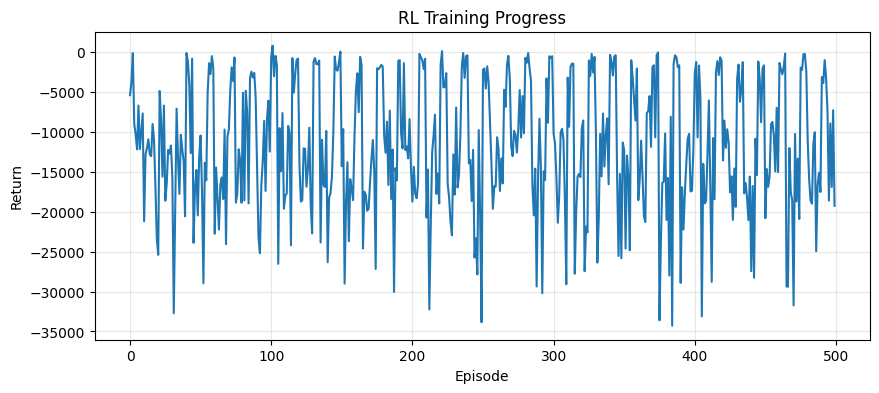


Trained policy final error: 15.7774


In [6]:
# Create and train RL controller
rl_ctrl = PolicyGradientController(
    n_states=2, n_actions=2,
    learning_rate=0.05,
    sigma=0.3,
    name="RL-PolicyGradient"
)
rl_ctrl.set_target(target)

print("Training RL agent (50 episodes)...")
returns = rl_ctrl.train(model, n_episodes=500, max_steps=100, verbose=False)

# Plot learning curve
plt.figure(figsize=(10, 4))
plt.plot(returns)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('RL Training Progress')
plt.grid(True, alpha=0.3)
plt.show()

# Test trained policy
sim = Simulator(model, rl_ctrl, disturbance_mode='random', seed=42)
rl_result = sim.run(x0, T, target)

print(f"\nTrained policy final error: {rl_result.error_norms[-1]:.4f}")

## 6. Reach-Avoid Symbolic Controller

Grid-based abstraction with graph search for obstacle avoidance.

Grid: 8100 cells
Safe cells: 7730
Obstacle cells: 370


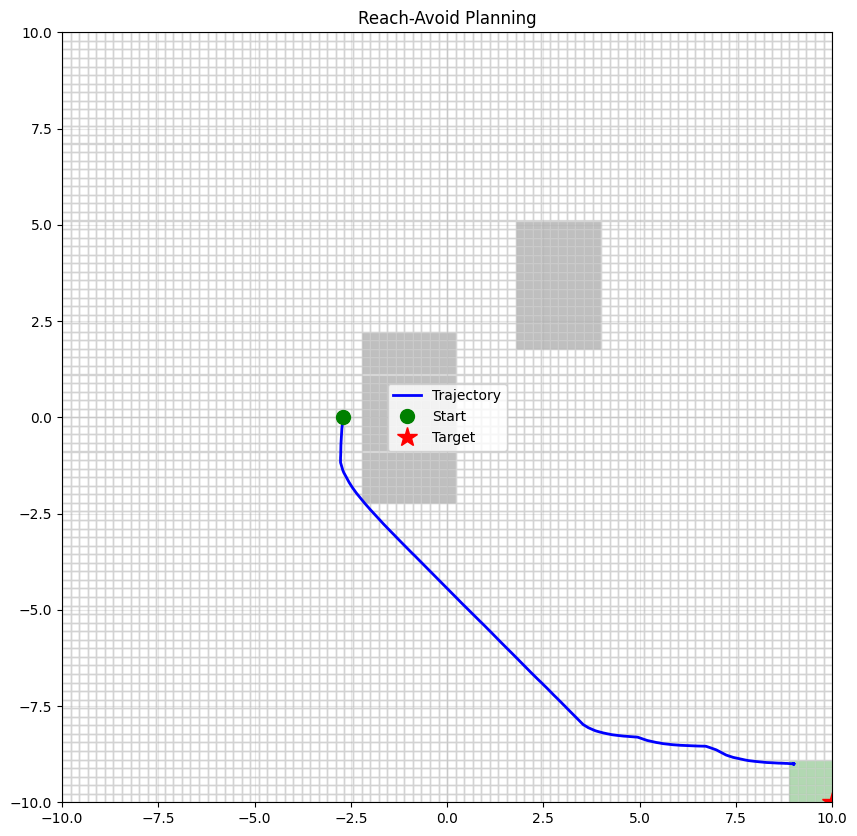

In [21]:
# Configuration
x0 = np.array([-2.7, 0.0])  # Initial state
target = np.array([10.0, -10.0])  # Target
T = 100.0  # Simulation time


# Create grid abstraction
abstraction = GridAbstraction(model.x_bounds, resolution=(90, 90), model=model)

# Define goal region
goal_region = np.array([[9, -11], [11, -11], [11, -9], [9, -9]])
abstraction.set_goal_region(goal_region)

# Define obstacles
obstacles = [
    np.array([[-2, -2], [0, -2], [0, 2], [-2, 2]]),
    np.array([[2, 2], [4, 2], [4, 5], [2, 5]])
]
abstraction.set_obstacles(obstacles)

print(f"Grid: {abstraction.n_cells} cells")
print(f"Safe cells: {len(abstraction.safe_cells)}")
print(f"Obstacle cells: {len(abstraction.obstacle_cells)}")

# Create planner and controller
planner = ReachAvoidPlanner(abstraction)
planner.compute_value_function()
planner.compute_policy()

ra_ctrl = ReachAvoidController(planner, waypoint_tolerance=0.5, kp=0.8, name="ReachAvoid")
ra_ctrl.set_model(model)

# Simulate
sim = Simulator(model, ra_ctrl, disturbance_mode='random', seed=42)
ra_result = sim.run(x0, 100.0)  # Longer time for path following

# Visualize
fig, ax = plt.subplots(figsize=(10, 10))
abstraction.visualize(ax)
ax.plot(ra_result.states[:, 0], ra_result.states[:, 1], 'b-', linewidth=2, label='Trajectory')
ax.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
ax.plot(target[0], target[1], 'r*', markersize=15, label='Target')
ax.legend()
ax.set_title('Reach-Avoid Planning')
plt.show()

## 7. Controller Comparison

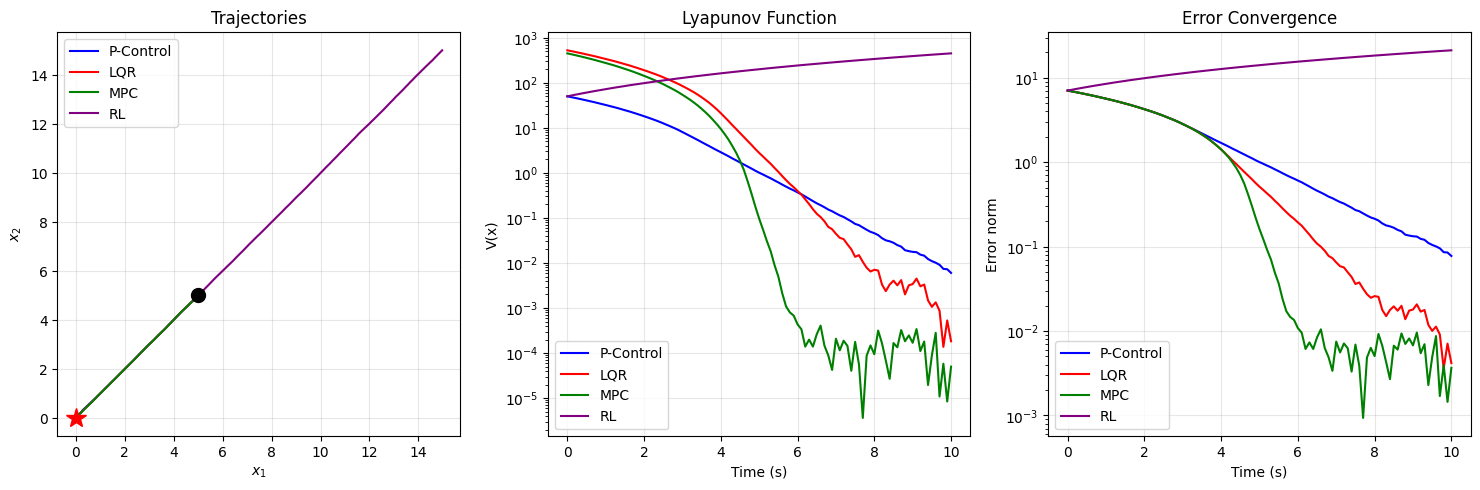


Performance Comparison:
------------------------------------------------------------
Controller      Final Error     Settling Time   Energy         
------------------------------------------------------------
P-Control       0.0776          8.80            8.0501         
LQR             0.0042          6.30            8.9955         
MPC             0.0037          5.10            9.6734         
RL              21.2046         inf             20.2000        


In [9]:
# Compare all controllers
results = [p_result, lqr_result, mpc_result, rl_result]
labels = ['P-Control', 'LQR', 'MPC', 'RL']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Trajectories
colors = ['blue', 'red', 'green', 'purple']
for result, label, color in zip(results, labels, colors):
    axes[0].plot(result.states[:, 0], result.states[:, 1], '-', 
                 color=color, linewidth=1.5, label=label)
axes[0].plot(x0[0], x0[1], 'ko', markersize=10)
axes[0].plot(target[0], target[1], 'r*', markersize=15)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_title('Trajectories')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# Lyapunov evolution
for result, label, color in zip(results, labels, colors):
    V = np.maximum(result.lyapunov_values, 1e-10)
    axes[1].semilogy(result.time, V, '-', color=color, linewidth=1.5, label=label)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('V(x)')
axes[1].set_title('Lyapunov Function')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Error convergence
for result, label, color in zip(results, labels, colors):
    axes[2].semilogy(result.time, result.error_norms + 1e-10, '-', 
                     color=color, linewidth=1.5, label=label)
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Error norm')
axes[2].set_title('Error Convergence')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance table
print("\nPerformance Comparison:")
print("-" * 60)
print(f"{'Controller':<15} {'Final Error':<15} {'Settling Time':<15} {'Energy':<15}")
print("-" * 60)
for result, label in zip(results, labels):
    metrics = result.compute_metrics()
    print(f"{label:<15} {result.error_norms[-1]:<15.4f} "
          f"{metrics.get('settling_time', float('inf')):<15.2f} "
          f"{metrics['input_energy']:<15.4f}")